In [2]:
import csv
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
dss = ['mnist', 'fashion_mnist', 'cifar10', 'cifar100', 'stl10']
colors = {'mnist':'b',
          'fashion_mnist': 'g',
          'cifar10': 'r',
          'cifar100': 'c',
          'stl10': 'm'}
ds_pretty_names = {'mnist':'MNIST',
                   'fashion_mnist': 'Fashion-MNIST',
                   'cifar10': 'CIFAR-10',
                   'cifar100': 'CIFAR-100',
                   'stl10': 'STL-10'}
num_epochs = 100 

fontsize = 25

epochs_header = ['epoch',
                 'accuracy',
                 'precision (micro)',
                 'precision (macro)',
                 'precision (weighted)',
                 'recall (micro)',
                 'recall (macro)',
                 'recall (weighted)',
                 'f1-measure (micro)',
                 'f1-measure (macro)',
                 'f1-measure (weighted)',
                 'loss',
                 'validation loss']
                 
meta_header   = ['model',
                 'num. layers',
                 'num. heads',
                 'stopped-at',
                 'n_segments',
                 'compactness',
                 'graph type',
                 'slic method',
                 'features',
                 'avg. num. of nodes',
                 'std. dev. of num. of nodes',
                 'avg. num. of edges',
                 'std. dev. of num. of edges',
                 'best epochs',
                 'last epochs',
                 'accuracy',
                 'precision micro',
                 'precision macro',
                 'precision weighted',
                 'recall micro',
                 'recall macro',
                 'recall weighted',
                 'micro',
                 'macro',
                 'weighted',
                 'avg. loss',
                 'training time',
                 'loading time']

# GCN tests

## Features

In [4]:
grey_dss = dss[0:2]
color_dss = dss[2:]
features_grey  = [['avg_color'],
                  ['avg_color','centroid'],
                  ['avg_color','centroid','std_deviation_color'],
                  ['avg_color','centroid','std_deviation_color','num_pixels'],
                  ['avg_color','centroid','std_deviation_color','std_deviation_centroid']]
features_color = [['avg_color'],
                  ['avg_color','centroid'],
                  ['avg_color','centroid','std_deviation_color'],
                  ['avg_color','centroid','std_deviation_color','num_pixels'],
                  ['avg_color','centroid','std_deviation_color','std_deviation_centroid'],
                  ['avg_color','centroid','std_deviation_color','std_deviation_centroid','avg_color_hsv'],
                  ['avg_color','centroid','std_deviation_color','std_deviation_centroid','avg_color_hsv','std_deviation_color_hsv']]
features_pretty = ['avg. color',
                  'avg. color + centroid', 
                  'avg. color + centroid + std. dev. color', 
                  'avg. color + centroid + std. dev. color \n + num. pixels', 
                  'avg. color + centroid + std. dev. color \n + std. dev. centroid', 
                  'avg. color + centroid + std. dev. color \n + std. dev. centroid + avg. color hsv',
                  'avg. color + centroid + std. dev. color \n + std. dev. centroid + avg. color hsv\n + std. dev. color hsv']

Epoch averages 

In [5]:
data_grey  = np.ndarray((len(grey_dss), len(features_grey), len(epochs_header), num_epochs), dtype=np.float64)
data_color = np.ndarray((len(color_dss), len(features_color), len(epochs_header), num_epochs), dtype=np.float64)

def load_data(datasets, features, data_arr):
    for dataset_index, dataset_name in enumerate(datasets):
        basedir = f'GCN/{dataset_name}/'
        for features_idx, features_list in enumerate(features):
            features_list.sort()
            filename = 'l3n75-RAG-SLIC0-{}.csv'.format('-'.join(features_list))
            with open(basedir + filename, newline='') as file:
                reader = csv.reader(file)
                for epoch_idx, epoch_info in enumerate(reader):
                    if epoch_idx > 0:
                        for v_idx, v in enumerate(epoch_info):
                            if v != '':
                                data_arr[dataset_index][features_idx][v_idx][epoch_idx - 1] = float(v)
                            else:
                                data_arr[dataset_index][features_idx][v_idx][epoch_idx - 1] = np.nan

load_data(grey_dss, features_grey, data_grey)
load_data(color_dss, features_color, data_color)

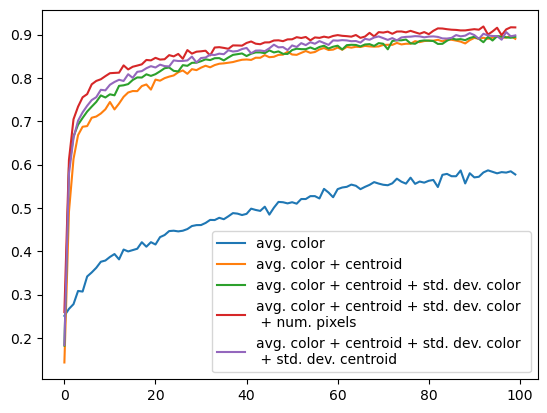

In [27]:
es = range(num_epochs)
for fi, fontsize in enumerate(features_grey):
    plt.plot(es, data_grey[0, fi, 9,:], label=features_pretty[fi])
plt.legend()
plt.show()

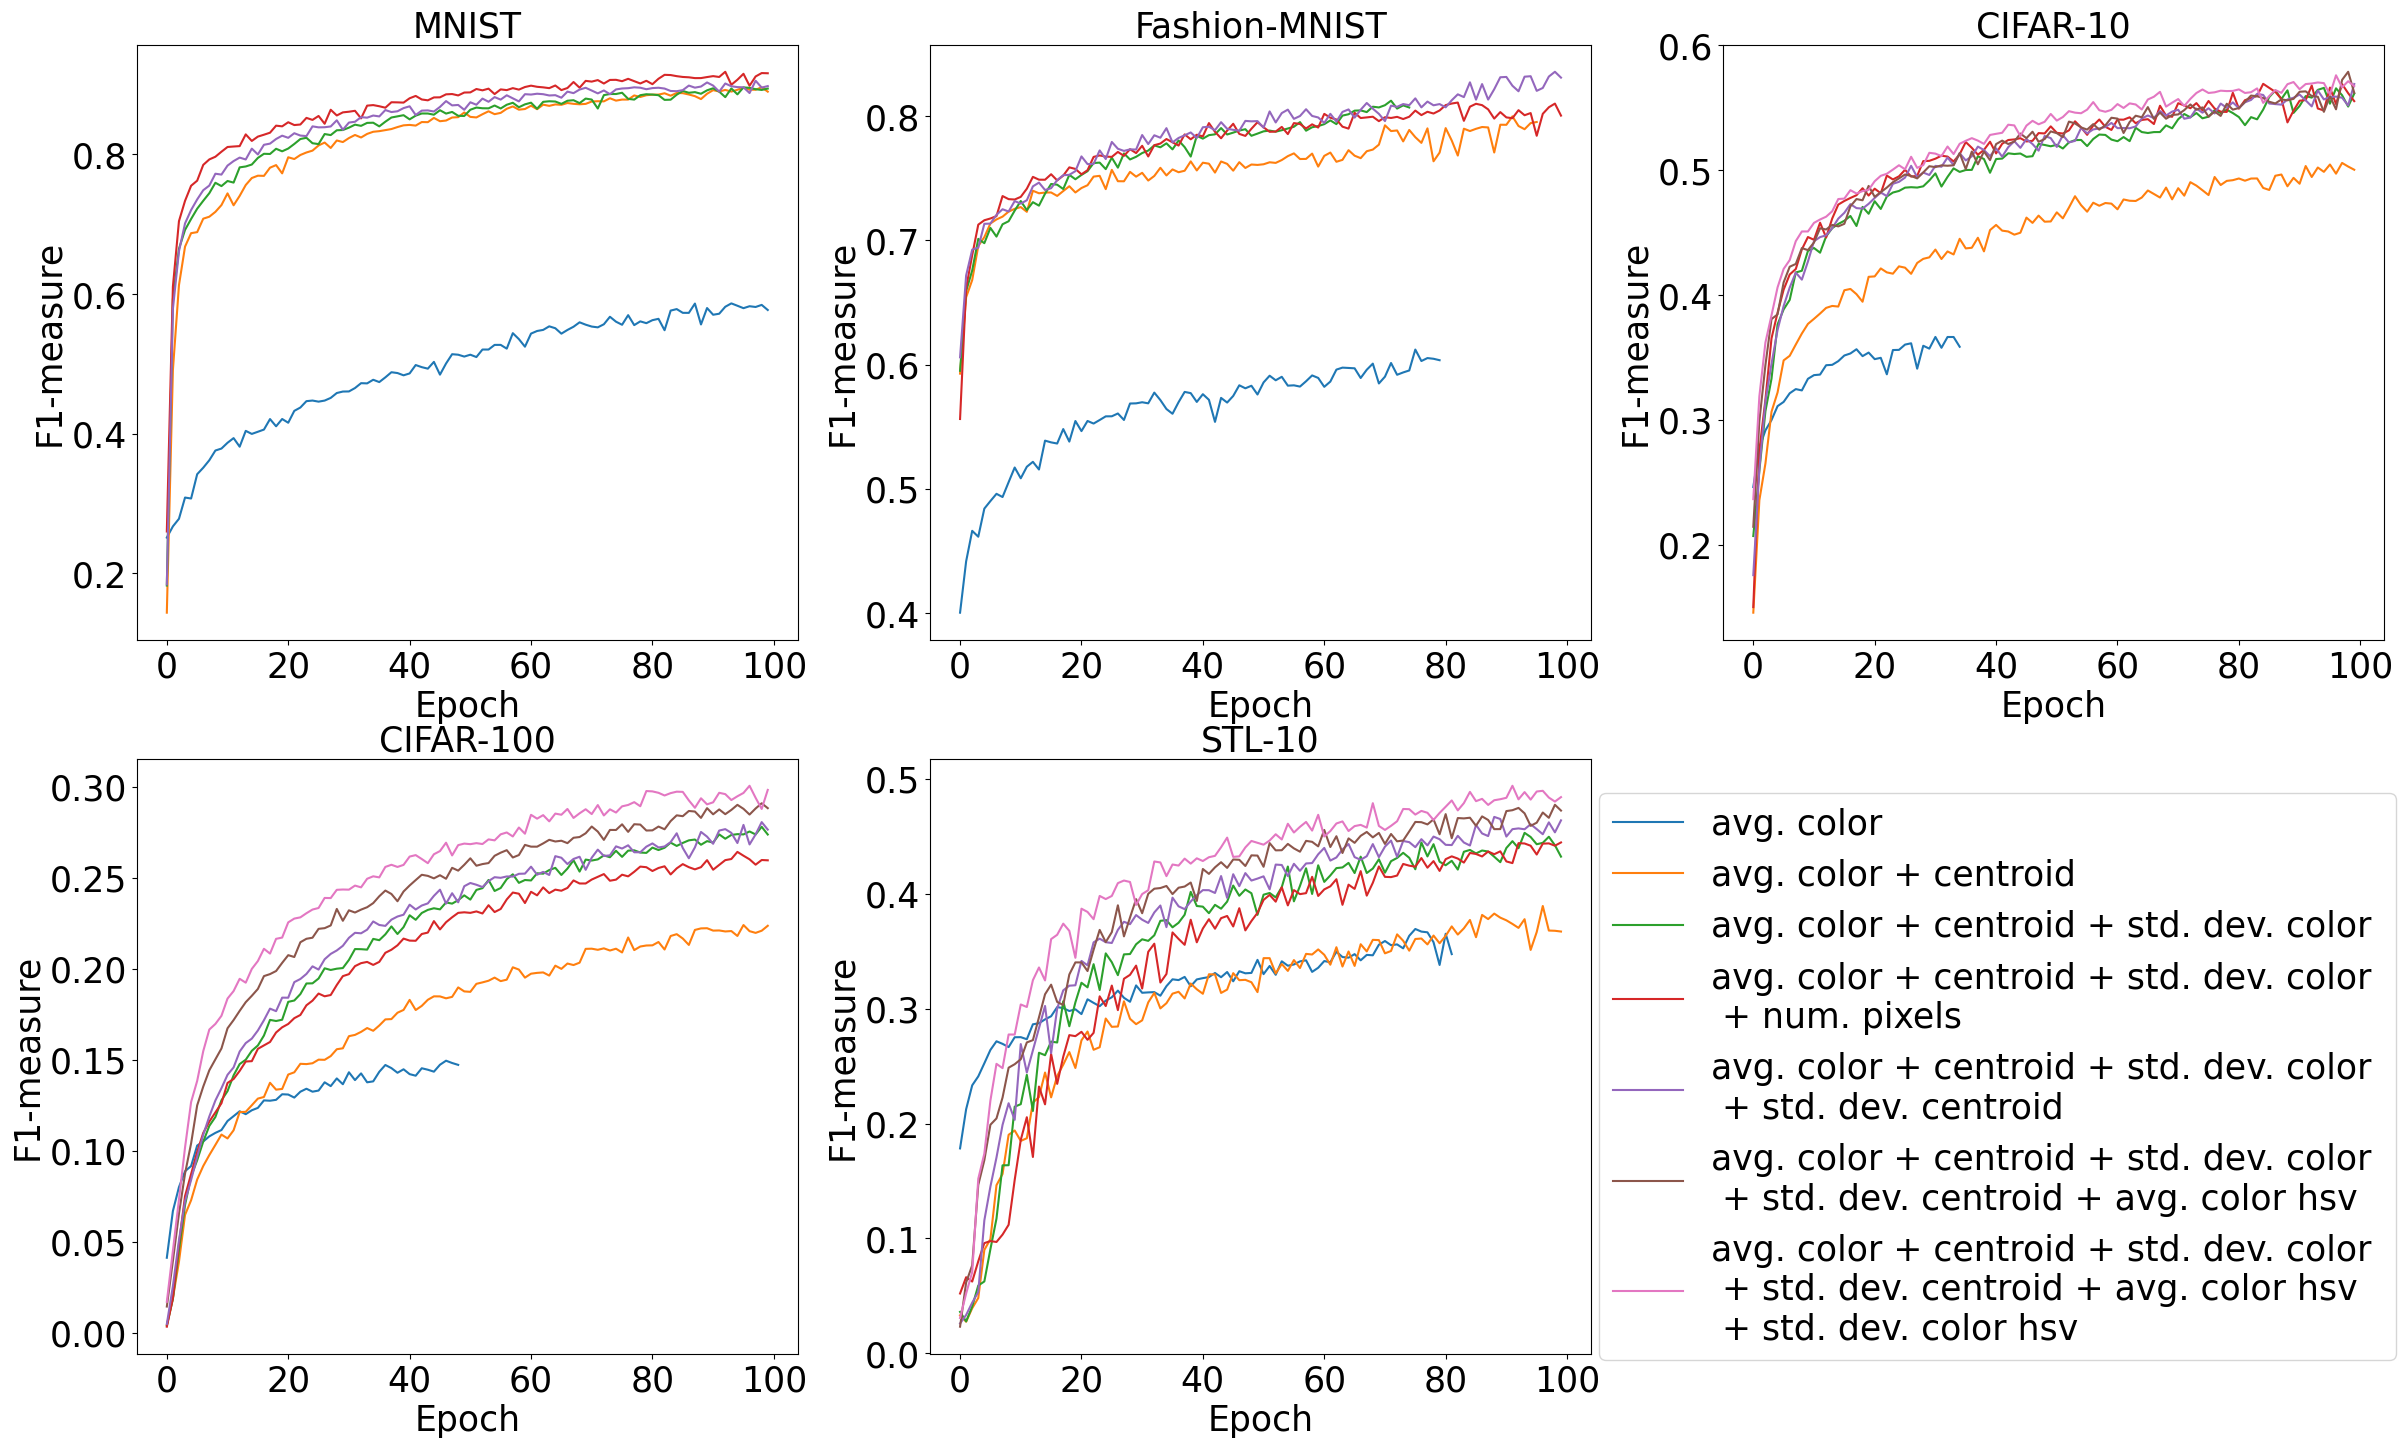

In [9]:
epochs = range(100)

rows, cols = 2, 3
figsize = (29, 17)
fig, ax = plt.subplots(rows, cols, figsize=figsize)
for dsi, ds in enumerate(dss):
    axi, axj = int(np.floor(dsi/cols)),  int(dsi % cols)
    grey_dsi = len(grey_dss)
    features = features_grey if dsi < grey_dsi else features_color
    data = data_grey if dsi < grey_dsi else data_color
    dataset_index_real = dsi if dsi < grey_dsi else dsi - grey_dsi
    ax[axi][axj].tick_params(labelsize=fontsize)
    for features_idx, features_name in enumerate(features):
        ax[axi][axj].set_xlabel('Epoch', fontsize=fontsize)
        ax[axi][axj].set_ylabel('F1-measure', fontsize=fontsize)
        ax[axi][axj].set_title(ds_pretty_names[ds], fontsize=fontsize)
        ax[axi][axj].plot(epochs, data[dataset_index_real][features_idx][9], label=features_pretty[features_idx])
ax[rows-1][cols-1].remove()
handles, labels = ax[rows-1][cols-2].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1 - 0.09, 0.45), fontsize=fontsize)
plt.savefig('imgs/features-f1macro-2cols.png', bbox_inches='tight')
plt.show()

Effective results

In [11]:
relevant_metrics = ['accuracy',
                    'precision micro',
                    'precision macro',
                    'precision weighted',
                    'recall micro',
                    'recall macro',
                    'recall weighted',
                    'micro',
                    'macro',
                    'weighted',
                    'avg. loss']

In [20]:
meta_data = np.ndarray((len(dss), len(features_color),len(relevant_metrics)), dtype=np.float64)
for dsi, ds in enumerate(dss):
    filename = f'GCN/{ds}-features.csv'
    with open(filename, newline='') as file:
        reader = csv.reader(file)
        for fli, line in enumerate(reader):
            mi = 0
            if fli > 0:
                for vi, v in enumerate(line):
                    if vi >= 15 and vi <= 25:
                        meta_data[dsi, fli-1, mi] = float(v)
                        mi += 1
            

In [24]:
fs = ['Avg. color', 'Centroid', 'Std. dev. color', 'Num. of pixels', 'Std. dev. centroid', 'Avg. HSV', 'Std. dev. HSV']
for i, f in enumerate(fs):
    line = f
    for dg, _ in enumerate(data_grey):
        if i > 4:
            line+="&-&-&-"
        else:
            acc  = meta_data[dg][i][0]
            f1   = meta_data[dg][i][8] 
            loss = meta_data[dg][i][10]
            line += f"&{acc*100:.1f}"
            line += f"&{f1*100:.1f}"
            line += f"&{loss*100:.1f}"
    for dc, _ in enumerate(data_color):
        acc  = meta_data[len(data_grey) + dc][i][0]
        f1   = meta_data[len(data_grey) + dc][i][8]
        loss = meta_data[len(data_grey) + dc][i][10]
        line += f"&{acc*100:.1f}"
        line += f"&{f1*100:.1f}"
        line += f"&{loss*100:.1f}"
    line += '\\\\'
    print(line)

Avg. color&59.3&58.7&121.8&59.8&59.6&104.7&36.6&35.9&176.6&16.0&13.7&355.2&35.1&33.9&179.5\\
Centroid&89.0&89.0&34.3&77.4&77.1&59.1&48.2&47.8&145.5&23.4&21.8&314.7&38.8&37.4&167.5\\
Std. dev. color&89.2&89.2&34.1&79.9&79.5&52.9&54.8&54.5&127.3&28.8&27.5&288.2&45.0&43.5&149.9\\
Num. of pixels&90.8&90.8&29.2&80.7&80.4&51.0&55.4&55.1&125.0&27.4&25.8&294.1&45.6&44.5&147.6\\
Std. dev. centroid&89.7&89.7&32.3&81.2&81.0&49.8&56.0&55.7&124.3&28.1&26.7&291.5&46.4&45.8&145.5\\
Avg. HSV&-&-&-&-&-&-&56.0&55.7&123.5&30.6&29.3&278.1&48.0&47.5&141.6\\
Std. dev. HSV&-&-&-&-&-&-&57.0&56.7&120.8&30.6&29.4&277.9&49.1&48.5&139.0\\
